In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from abc import ABC, abstractmethod
from dataclasses import dataclass
from queue import PriorityQueue
from functools import total_ordering

%load_ext line_profiler

In [2]:
sns.set(color_codes=True, style='whitegrid', context='paper')
plt.rcParams["figure.figsize"] = 15, 10

In [3]:
quotes_filename = os.path.join("play_data", "XBTUSD_quotes_191214_0434.csv")
trades_filename = os.path.join("play_data", "XBTUSD_trades_191214_0434.csv")

In [4]:
quotes_full = pd.read_csv(
    quotes_filename,
    index_col='recorded',
    parse_dates=['timestamp', 'recorded']
)
quotes_full.head()

timestamp  bidSize  \
recorded                                                                     
2019-12-14 04:34:40.731941+00:00 2019-12-14 04:34:40.024000+00:00  3840427   
2019-12-14 04:34:41.211565+00:00 2019-12-14 04:34:40.410000+00:00  3840391   
2019-12-14 04:34:42.210955+00:00 2019-12-14 04:34:41.165000+00:00  3840391   
2019-12-14 04:34:42.210955+00:00 2019-12-14 04:34:41.183000+00:00  3840187   
2019-12-14 04:34:42.210955+00:00 2019-12-14 04:34:41.431000+00:00  3840187   

                                  bidPrice  askPrice  askSize  
recorded                                                       
2019-12-14 04:34:40.731941+00:00    7251.5    7252.0   701477  
2019-12-14 04:34:41.211565+00:00    7251.5    7252.0   701477  
2019-12-14 04:34:42.210955+00:00    7251.5    7252.0   731477  
2019-12-14 04:34:42.210955+00:00    7251.5    7252.0   731277  
2019-12-14 04:34:42.210955+00:00    7251.5    7252.0   715277

In [5]:
trades_full = pd.read_csv(
    trades_filename,
    index_col='received',
    parse_dates=['timestamp', 'received']
)
trades_full.head()

timestamp  side  \
received                                                                  
2019-12-14 04:34:40.742081+00:00 2019-12-14 04:34:38.713000+00:00  Sell   
2019-12-14 04:34:42.499730+00:00 2019-12-14 04:34:42.378000+00:00   Buy   
2019-12-14 04:34:48.168746+00:00 2019-12-14 04:34:48.044000+00:00   Buy   
2019-12-14 04:34:48.332053+00:00 2019-12-14 04:34:48.213000+00:00   Buy   
2019-12-14 04:34:50.665331+00:00 2019-12-14 04:34:50.504000+00:00   Buy   

                                    size   price  
received                                          
2019-12-14 04:34:40.742081+00:00    2500  7251.5  
2019-12-14 04:34:42.499730+00:00   12000  7252.0  
2019-12-14 04:34:48.168746+00:00  100000  7252.0  
2019-12-14 04:34:48.332053+00:00     116  7252.0  
2019-12-14 04:34:50.665331+00:00    2500  7252.0

In [6]:
df = pd.read_csv(
    "play_data/XBTUSD_trades_191214_0434.csv",
    usecols=[
        "received",
        "size",
        "price"
    ],
    parse_dates=["received"],
    index_col="received",
    nrows=30000
)

In [7]:
@total_ordering
class Event(ABC):
    def __post_init__(self):
        assert type(self.event_time) == pd.Timestamp,\
        "pd.Timestamp event_time required"
    def __eq__(self, other):
        return self.event_time == other.event_time
    def __lt__(self, other):
        return self.event_time < other.event_time
    
@dataclass
class DataEvent(Event):
    __slots__ = "event_time", "table_name", "data"
    event_time : pd.Timestamp
    table_name : str
    data : pd.Series
        
        
class EventQueue(PriorityQueue):
    def __init__(self, start_time, *args, **kwargs):
        self.current_time = start_time
        return super().__init__(*args, **kwargs)
        
    def get(self, *args, **kwargs):  # may be bad for performance
        event = super().get(*args, **kwargs)
        self.current_time = event.event_time
        return event

    
class DataHandler:
    def __init__(self, queue, start_time, all_data):
        self.queue = queue
        self.past_data_dict = self.split_past_data(all_data, start_time)  # dict of lists of series
        self.load_future_data_into_queue(all_data, start_time)
    
    def split_past_data(self, all_data, start_time):
        past_data = {}
        for table_name, df in all_data.items():  # for each table
            past_data[table_name] = []
            for event_time, row in df[:start_time].iterrows():  # for each row
                past_data[table_name].append(row)
        return past_data
    
    def read_table(self, table_name):
        return pd.DataFrame(self.past_data_dict[table_name])
        
    def load_future_data_into_queue(self, all_data, start_time):
        for table_name, df in all_data.items():  # for each table
            for event_time, data in df[:start_time].iterrows():  # for each row
                self.queue.put(DataEvent(event_time, table_name, data))
        return None
    
    def update_data(self, data_event):
        table = data_event.table_name
        data = data_event.data
        self.past_data_dict[table].append(data)
        return None
        

In [8]:
start_time = df.index[15000]
eq = EventQueue(start_time)
all_data = {"df_table": df}
dh = DataHandler(eq, start_time, all_data)

display( dh.read_table("df_table").tail() )

dh.update_data(eq.get())
print(eq.current_time)
display( dh.read_table("df_table").tail() )

dh.update_data(eq.get())
print(eq.current_time)
display( dh.read_table("df_table").tail() )

size   price
2019-12-14 06:51:05.574798+00:00    51.0  7240.5
2019-12-14 06:51:05.574798+00:00    43.0  7240.5
2019-12-14 06:51:05.574798+00:00  1000.0  7240.5
2019-12-14 06:51:05.574798+00:00    56.0  7240.5
2019-12-14 06:51:05.574798+00:00  7777.0  7240.5

2019-12-14 04:34:40.742081+00:00


size   price
2019-12-14 06:51:05.574798+00:00    43.0  7240.5
2019-12-14 06:51:05.574798+00:00  1000.0  7240.5
2019-12-14 06:51:05.574798+00:00    56.0  7240.5
2019-12-14 06:51:05.574798+00:00  7777.0  7240.5
2019-12-14 04:34:40.742081+00:00  2500.0  7251.5

2019-12-14 04:34:42.499730+00:00


size   price
2019-12-14 06:51:05.574798+00:00   1000.0  7240.5
2019-12-14 06:51:05.574798+00:00     56.0  7240.5
2019-12-14 06:51:05.574798+00:00   7777.0  7240.5
2019-12-14 04:34:40.742081+00:00   2500.0  7251.5
2019-12-14 04:34:42.499730+00:00  12000.0  7252.0

In [9]:
class Strategy(ABC):
    @abstractmethod
    def generate_signal(self):
        pass

class DollarWeightedMACD(Strategy):
    @dataclass
    class DWMParameters:
        __slots__ = "group_width", "short_ma_window", "long_ma_window"
        group_width: float
        short_ma_window: int
        long_ma_window: int

    @dataclass
    class DWMCache:
        __slots__ = "ma_vals", "increasing", "curr_bar", "remaining_width"
        ma_vals: np.array  # each element is dwap, for each item in the window
        increasing: bool  # used to check direction changes to prevent duplicates
        curr_bar: pd.DataFrame  # columns: size, price, dollars
        remaining_width: float # when curr bar full, update MAs
        
    def make_dwap_df_and_curr_bar(self, df, group_width):
        df["dollars"] = df["size"] * df["price"]
        df["group"] = (df["dollars"].cumsum() // group_width)  # will be affected by different initial conditions
        new_series = {}  # timestamp : dollar weighted average price

        for grp, gdf in df.groupby("group"):
            timestamp = gdf.index[-1] # last timing, prevent lookahead
            dwap = (gdf["dollars"].values * gdf["price"].values).sum() / gdf["dollars"].values.sum()
            if grp == df["group"].max():
                curr_bar = gdf[["size", "price", "dollars"]].values  # for cache
            new_series[timestamp] = dwap
            
        ddf = pd.Series(new_series, name="dwap").to_frame()
        return ddf, curr_bar

    def __init__(self, df):
        group_width = 680850400  # arbitrary, eventually can dynamically adjust
        short_ma, long_ma = 5, 10  # maybe can EWM but will need more parameters
        
        self.ddf, curr_bar = self.make_dwap_df_and_curr_bar(df, group_width)
        
        ma_vals = self.ddf["dwap"].values[-long_ma:]
        increasing = ma_vals[-short_ma:].sum()/short_ma > ma_vals.sum()/long_ma
        rem_width = group_width - (df["dollars"].cumsum().values % group_width)[-1]

        self.cache = self.DWMCache(ma_vals, increasing, curr_bar, rem_width)
        self.params = self.DWMParameters(group_width, short_ma, long_ma)
        return None
        
    def generate_signal(self, size, price):  
        # also updates cache, inefficient
        # should rewrite such that chache update is separate
        # needs to be updated such that it uses Signal objects
        
        new_row = np.array([[size, price, size*price]])
        dols = new_row[0,2]
        self.cache.remaining_width -= new_row[0,2]
        
        if self.cache.remaining_width > 0:  # old bar, update last val
            self.cache.curr_bar = np.append(self.cache.curr_bar, new_row, axis=0)
            
        else:  # new bar, does not account big txn that exceeds group width
            self.cache.remaining_width += self.params.group_width
            self.cache.curr_bar = new_row
            self.cache.ma_vals = np.roll(self.cache.ma_vals, -1)
            
        self.cache.ma_vals[-1] = ((self.cache.curr_bar[:,1] * self.cache.curr_bar[:,2]).sum() 
                                  / self.cache.curr_bar[:,2].sum())
        
        long_sma = self.cache.ma_vals.sum() / self.params.long_ma_window
        short_sma = self.cache.ma_vals[-self.params.short_ma_window:].sum()/self.params.short_ma_window
        inc = short_sma > long_sma
        old_inc = self.cache.increasing
        self.cache.increasing = inc
        
        # old_inc!=inc: whether there is a direction change
        # (-1)**(not inc): whether we want to long or short (1 if increasing, -1 if decreasing)
        return (old_inc!=inc) * (-1)**(not inc)
        
    def update_cache(self, size, price):
        # currently done inside generate signal
        # have to redo logic later if it works 
        print("updating cache")
        return None
    
    def update_parameters(self, df):
        # assumes df will be updated with all the relevant data
        print("updating parameters")
        return None

1
0
-1
1


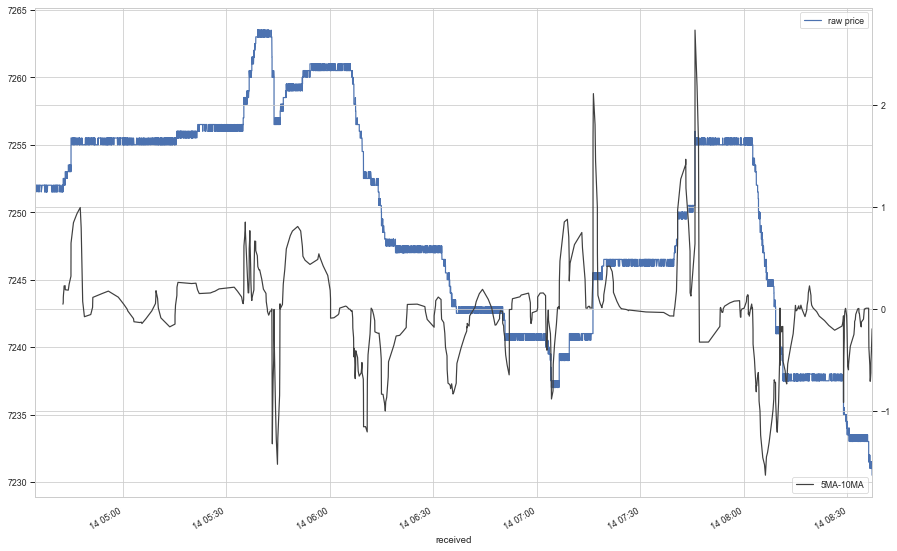

In [10]:
def _plot(df, dwap_strat):
    ax1 = df["price"].plot(label='raw price')
    plt.legend()
    
    ax2 = ax1.twinx()
    short_ma = dwap_strat.params.short_ma_window
    long_ma = dwap_strat.params.long_ma_window
    ddf = dwap_strat.ddf
    short_sma = ddf["dwap"].rolling(short_ma).mean()
    long_sma = ddf["dwap"].rolling(long_ma).mean()
    ax2.plot(short_sma-long_sma, label=f"{short_ma}MA-{long_ma}MA", c="0.25")
    plt.legend(loc="lower right")
    return None

d = DollarWeightedMACD(df)

_plot(df, d)

print( d.generate_signal(100000, 7500) )
print( d.generate_signal(200000, 7000) )
print( d.generate_signal(100000, 7000) )
print( d.generate_signal(100000, 8000) )